# <center>Solution 1 of Homework1 Practice part IFT6135</center>

#### Team Member

Kun Ni(20139672), Yishi Xu(20125387), Jinfang Luo(20111308), Yan Ai(20027063)

#### Coding Environment
python 3.7.1, numpy 1.15.2 matplotlib 2.2.0


#### The link to github repo for our report.
https://github.com/ekunnii/ift6135-submission/tree/master/assignment1

---------------


# Problem 1

In this problem, we will build a Multilayer Perceptron (MLP) and train it on the MNIST hand-written digit dataset.

__Building the Model__ [35] Consider an MLP with two hidden layers with $h^1$ and $h^2$ hidden units.
For the MNIST dataset, the number of features of the input data $h^0$ is 784. The output of the
neural network is parameterized by a softmax of $h^3=10$ classes.

1. Build an MLP and choose the values of h1 and h2 such that the total number of parameters (including biases) falls within the range of [0.5M, 1.0M].

The total number of parameters including biases for the MLP are:

total number of parameters=(h1\_hidden\_units$*$features(784)+h1\_hidden\_units) + (h2\_hidden\_units$*$h1\_hidden\_units+h2\_hidden\_units) + (outputs(10)$*$h2\_hidden\_units+outputs(10)), it should be in range of [0.5M, 1.0M].

For example:

option1: h1_hidden_units = 512, h2_hidden_units = 256, total number of parameters = 535818

option2: h1_hidden_units = 600, h2_hidden_units = 600, total number of parameters = 837610

We could get the total number of parameters with below function:

In [31]:
def calculate_total_paramters(h1_n, h2_n):
    sum = (h1_n*784+h1_n) + ((h2_n*h1_n)+h2_n) + ((10*h2_n)+10)
    print('With h1 hidden units: {0}, h2 hidden units: {1}, total number of parameters: {2}'.format(h1_n, h2_n, sum))
    
calculate_total_paramters(512,256)
calculate_total_paramters(600,600)
calculate_total_paramters(710,610)

With h1 hidden units: 512, h2 hidden units: 256, total number of parameters: 535818
With h1 hidden units: 600, h2 hidden units: 600, total number of parameters: 837610
With h1 hidden units: 710, h2 hidden units: 610, total number of parameters: 997170


2. Implement the forward and backward propagation of the MLP in numpy without using any of the deep learning frameworks that provides automatic dierentiation. Use the class structure provided here.

3. Train the MLP using the probability loss (cross entropy) as training criterion. We minimize this criterion to optimize the model parameters using stochastic gradient descent.

In [32]:
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import random
import time
from datetime import datetime
import os

import pdb

In [33]:
class MLP_NN(object):
    def initialize_weights(self, method):
        if method == 'zeros':
            self.w1 = np.zeros((self.h1, self.features))     # return h1 * features matrix
            self.w2 = np.zeros((self.h2, self.h1))           # return h2 * h1 matrix
            self.w3 = np.zeros((self.outputs, self.h2))      # return outputs * h2
        elif method == 'normal':
            self.w1 = np.random.normal(0, 1, size=(self.h1, self.features))
            self.w2 = np.random.normal(0, 1, size=(self.h2, self.h1))
            self.w3 = np.random.normal(0, 1, size=(self.outputs, self.h2))
        elif method == 'glorot':
            d1 = np.sqrt(6/(self.features+self.h1))
            self.w1 = np.random.uniform(-d1, d1, size=(self.h1, self.features))
            d2 = np.sqrt(6/(self.h1+self.h2))
            self.w2 = np.random.uniform(-d2, d2, size=(self.h2, self.h1))
            d3 = np.sqrt(6/(self.h2+self.outputs))
            self.w3 = np.random.uniform(-d3, d3, size=(self.outputs, self.h2))
        return self.w1, self.w2, self.w3

    def initialize_biases(self):
        """
        Initialize biases at zeros.
        :return: biases for hidden layer and output layer
        """

        self.h1_b = np.zeros((self.h1, 1))
        self.h2_b = np.zeros((self.h2, 1))
        self.output_b = np.zeros((self.outputs, 1))

        return self.h1_b, self.h2_b, self.output_b

    def one_hot(self, y):
        z = []
        y = y.T
        for i in range(len(y)):
            z.append(np.eye(self.num_labels)[int(y[i])])
        z = np.matrix(z).T
        return z

    def import_data(self):
        f = gzip.open('./mnist.pkl.gz')
        # encoding='latin1' --> https://stackoverflow.com/a/41366785
        data = pickle.load(f, encoding='latin1')

        train_data = np.array(data[0][0], dtype=float)
        train_label = np.array(data[0][1], dtype=float)

        valid_data = np.array(data[1][0], dtype=float)
        valid_label = np.array(data[1][1], dtype=float)

        test_data = np.array(data[2][0], dtype=float)
        test_label = np.array(data[2][1], dtype=float)

        return train_data,train_label,valid_data,valid_label,test_data,test_label

    def activation(self, x, function):

        if function == 'sigmoid':
            z = 1/(1+np.exp(-x))

        elif function == 'relu':
            z = np.maximum(0, x)

        elif function == 'softmax':
            z = np.ones((x.shape[0], x.shape[1]))
            x_max = x.max(axis=0)
            a = x - x_max
            norm = np.sum(np.exp(a), axis=0)
            for i in range(x.shape[1]):
                z[:, i] = (np.exp(a[:, i]) / norm[i])
        return z

    def deactivation(self, A, function):
        if function == 'relu_backward':
            Z = np.int64(A > 0)
        elif function == 'sigmoid_backward':
            y = self.activation(A, 'sigmoid')
            Z = y * (1-y)
        return Z

    def forward(self, X, parameters):
        if X.shape[1] != self.features:
            raise ValueError('Inputs length does not match the input of the network')

        self.w1 = parameters["W1"]
        self.b1 = parameters["b1"]
        self.w2 = parameters["W2"]
        self.b2 = parameters["b2"]
        self.w3 = parameters["W3"]
        self.b3 = parameters["b3"]

        self.a1 = np.dot(self.w1, X.T) + self.b1
        self.o1 = self.activation(self.a1, 'relu')
        self.a2 = np.dot(self.w2, self.o1) + self.b2
        self.o2 = self.activation(self.a2, 'relu')
        self.a3 = np.dot(self.w3, self.o2) + self.b3
        self.o3 = self.activation(self.a3, 'softmax')

        cache = (self.a1, self.o1, self.w1, self.b1, self.o2, self.a2, self.w2, self.b2, self.a3, self.o3, self.w3, self.b3)

        return cache

    def loss(self, X, y, cache):
        # y is label, not onehot
        J = 0
        m = X.shape[0]
        a1, o1, w1, b1, o2, a2, w2, b2, a3, o3, w3, b3 = cache
        for i in range(m):
            loss = -np.log(o3[int(y[i])][i]+1e-10)
            J = J + loss
        J = J/m
        return J

    def back_propagation(self, X, y_onehot, cache):
        m = X.shape[0]
        a1, o1, w1, b1, o2, a2, w2, b2, a3, o3, w3, b3 = cache

        grad_a3 = o3 - y_onehot
        grad_w3 = np.dot(grad_a3, o2.T) / m
        grad_b3 = np.sum(grad_a3, axis=1) / m

        grad_o2 = np.dot(w3.T, grad_a3)
        d_a2 = self.deactivation(a2, 'relu_backward')
        grad_a2 = np.multiply(grad_o2, d_a2)
        grad_w2 = np.dot(grad_a2, o1.T) / m
        grad_b2 = np.sum(grad_a2, axis=1) / m


        grad_o1 = np.dot(w2.T, grad_a2)
        d_a1 = self.deactivation(a1, 'relu_backward')
        grad_a1 = np.multiply(grad_o1, d_a1)

        grad_w1 = np.dot(grad_a1, X) / m
        grad_b1 = np.sum(grad_a1, axis=1) / m

        gradients = {"dZ3": grad_a3, "dW3": grad_w3, "db3": grad_b3,
                     "dA2": grad_o2, "dZ2": grad_a2, "dW2": grad_w2, "db2": grad_b2,
                     "dA1": grad_o1, "dZ1": grad_a1, "dW1": grad_w1, "db1": grad_b1}
        return gradients

    def update(self, X, y_onehot, cache,learning_rate):
        gradients = self.back_propagation(X,y_onehot,cache)
        grad_w3, grad_w2, grad_w1, grad_b3, grad_b2, grad_b1 = gradients['dW3'], gradients['dW2'], gradients['dW1'], gradients['db3'], gradients['db2'], gradients['db1']
        n = X.shape[0]

        self.w3 -= learning_rate * grad_w3
        self.w2 -= learning_rate * grad_w2
        self.w1 -= learning_rate * grad_w1

        self.b3 -= learning_rate * grad_b3
        self.b2 -= learning_rate * grad_b2
        self.b1 -= learning_rate * grad_b1
        return self.w3, self.w2, self.w1, self.b3, self.b2, self.b1    

    def train(self, X, y_onehot, parameters, minibatches, lamb, p):
        n = minibatches
        set = X[p * n:p * n + n][:]
        #y1 = y[p * n:p * n + n][:]
        y1_onehot = y_onehot[:, p * n:p * n + n]

        batch_cache = self.forward(set, parameters)

        self.w3, self.w2, self.w1, self.b3, self.b2, self.b1 = self.update(set, y1_onehot, batch_cache, lamb)
        update_parameters = {"W1": self.w1,
                             "b1": self.b1,
                             "W2": self.w2,
                             "b2": self.b2,
                             "W3": self.w3,
                             "b3": self.b3}
        return update_parameters

    def test(self, X, y, parameters):
        accuracy = 0
        cache = self.forward(X, parameters)
        a1, o1, w1, b1, o2, a2, w2, b2, a3, o3, w3, b3 = cache
        y1 = self.one_hot(y)
        k = np.argmax(o3, axis=0)
        idx = np.argmax(y1, axis=0).tolist()
        real_idx = np.array(idx[0])
        num = X.shape[0]
        for j in range(num):
            if k[j] == real_idx[j]:
                accuracy += 1
        accuracy /= num
        accuracy *= 100

        loss = self.loss(X, y, cache)
        print('The accuracy in validation set is: {0}% and loss: {1}'.format(accuracy, loss))
        return accuracy, loss

    def __init__(self,
                 features=784,
                 h1=710,
                 h2=610,
                 outputs=10,
                 num_labels = 10,
                 epoch = 1000,
                 minibatches=8,
                 learning_rate = 0.001
                 ):
        self.features, self.h1, self.h2, self.outputs = features, h1, h2, outputs
        self.num_labels = num_labels
        self.epoch = epoch
        self.minibatches = minibatches
        self.learning_rate = learning_rate

In the following sub-questions, please specify the model architecture (number of hidden units per layer, and the total number of parameters), the nonlinearity chosen as neuron activation, learning rate, mini-batch size.

__Initialization__ [10] In this sub-question, we consider dierent initial values for the weight parameters. Set the biases to be zeros, and consider the following settings for the weight parameters:

+ __Zero__: all weight parameters are initialized to be zeros (like biases).
+ __Normal__: sample the initial weight values from a standard Normal distribution; $w_{i,j} \sim N(w_{i,j};0,1)$
+ __Glorot__: sample the initial weight values from a uniform distribution; $w_{i,j}^l \sim U(w_{i,j}^l;-d^l, d^l)$ where $d^l=\sqrt\frac{6}{h^{l-1}+h^l}$

1. Train the model for 10 epochs using the initialization methods above and record the average loss measured on the training data at the end of each epoch (10 values for each setup).
2. Compare the three setups by plotting the losses against the training time (epoch) and comment on the result.

In [41]:
    def loss_with_initial(class_name, initial_method):
        '''
        :param class_name: P1_initial1
        :param initial_method: zeros, normal, golrot
        :return: loss list with 10 epochs
        '''
        w1, w2, w3 = class_name.initialize_weights(initial_method)
        b1, b2, b3 = class_name.initialize_biases()
        parameters = {"W1": w1,
                      "b1": b1,
                      "W2": w2,
                      "b2": b2,
                      "W3": w3,
                      "b3": b3}

        train_data, train_label, valid_data, valid_label, test_data, test_label = class_name.import_data()
        X = train_data
        y = train_label
        y_onehot = class_name.one_hot(y)
        m = X.shape[0]

        # setting the network structure
        h1 = 600
        h2 = 600
        minibatches = 8
        epoch = 10
        learning_rate = 0.01

        batch = int(m/minibatches)
        losslist = []

        print('NN structure: {0} * {1}, with epoch: {2}, minibatch: {3}, learning rate: {4}'.format(h1, h2, epoch, minibatches, learning_rate))
        print('active function in layer 1: relu')
        print('active function in layer 2: relu')

        for i in range(epoch+1):
            cache = class_name.forward(X, parameters)
            #print('Epoch: ', i, 'of ', epoch, ' training...')
            loss = class_name.loss(X, y, cache)
            losslist.append(loss)
            #print('The loss in training set is: {0}'.format(loss))

            for p in range(batch):
                parameters = class_name.train(X, y_onehot, parameters, minibatches, learning_rate, p)
        print('Finished... Saved loss in list.')
        return losslist

*** initial with zeros ***
NN structure: 600 * 600, with epoch: 10, minibatch: 8, learning rate: 0.01
active function in layer 1: relu
active function in layer 2: relu
Finished... Saved loss in list.
*** Initial with normal ***
NN structure: 600 * 600, with epoch: 10, minibatch: 8, learning rate: 0.01
active function in layer 1: relu
active function in layer 2: relu
Finished... Saved loss in list.
*** Initial with glorot ***
NN structure: 600 * 600, with epoch: 10, minibatch: 8, learning rate: 0.01
active function in layer 1: relu
active function in layer 2: relu
Finished... Saved loss in list.


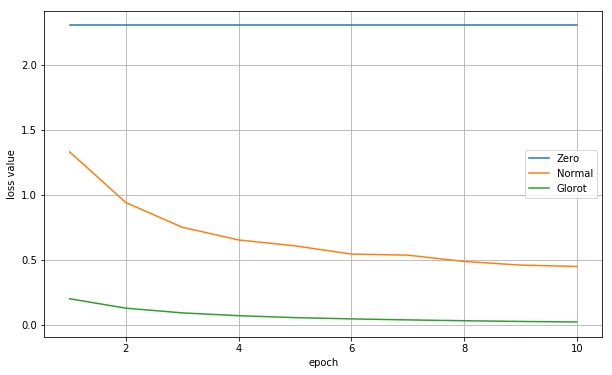

In [42]:
P1_initial1 = MLP_NN()
P1_initial2 = MLP_NN()
P1_initial3 = MLP_NN()

initial_zeros = []
initial_normal = []
initial_glorot = []

print('*** initial with zeros ***')
initial_zeros = loss_with_initial(P1_initial1, 'zeros')

print('*** Initial with normal ***')
initial_normal = loss_with_initial(P1_initial2, 'normal')

print('*** Initial with glorot ***')
initial_glorot = loss_with_initial(P1_initial3, 'glorot')

xaxis = np.linspace(1, 10, 10)
plt.figure(figsize=(10,6))
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.plot(xaxis, initial_zeros[1:], '-')
plt.plot(xaxis, initial_normal[1:], '-')
plt.plot(xaxis, initial_glorot[1:], '-')
plt.grid()
plt.legend(('Zero', 'Normal', 'Glorot'))
plt.show()

__Hyperparameter Search__ From now on, use the Glorot initialization method.

1. Find out a combination of hyper-parameters (model architecture, learning rate, nonlinearity, etc.) such that the average accuracy rate on the validation set $(r^{(valid)})$ is at least 97%.

2. Report the hyper-parameters you tried and the corresponding $r^{(valid)}$

The hyper-parameters we tried:

| h1 | h2 | h1_act | h2_act | batch_size | learning rate | epoch | train_accu | train_loss | valid_accu | valid_loss| 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| 512 | 256 | sigmoid | relu | 8 | 0.01 | 24 | 97.94% | 0.0739 | 97.04% | 0.1016 |
| 512 | 256 | relu | relu | 8 | 0.01 | 8 | 97.53% | 0.0928 | 97.10% | 0.1077 |
| 512 | 256 | sigmoid | sigmoid | 8 | 0.01 | 50 | 97.86% | 0.0831 | 96.99% | 0.1083 |
| 512 | 256 | relu | relu | 8 | 0.01 | 3 | 98.01% | 0.0766 | 97.16% | 0.0994 |
| 512 | 256 | relu | relu | 32 | 0.01 | 11 | 97.92% | 0.0838 | 97.06% | 0.1059 |
| 512 | 256 | relu | relu | 32 | 0.001 | 50 | 95.64% | 0.1607 | 95.65% | 0.1614 |
| 710 | 610 | relu | relu | 32 | 0.01 | 10 | 97.77% | 0.0885 | 97.00% | 0.1084 |
| 710 | 610 | relu | relu | 8 | 0.01 | 3 | 98.00% | 0.0753 | 97.07% | 0.0993 |
| 710 | 610 | relu | relu | 4 | 0.01 | 2 | 98.30% | 0.0628 | 97.11% | 0.0929 |

From these sets of hyper-parameters, we choose:

- Relu as the activation function

- 0.01 as learning rate

- 8 or less than 8 as batch size

- 710 and 610 as hidden units for two layers

In [38]:
#=== Hyperparameter Search ===
P1_hyper = MLP_NN()

# setting the network structure
P1_hyper.h1 = 710
P1_hyper.h2 = 610
P1_hyper.minibatches = 8
P1_hyper.epoch = 10
P1_hyper.learning_rate = 0.01

w1, w2, w3 = P1_hyper.initialize_weights('glorot')
b1, b2, b3 = P1_hyper.initialize_biases()
parameters = {"W1": w1,
              "b1": b1,
              "W2": w2,
              "b2": b2,
              "W3": w3,
              "b3": b3}

train_data, train_label, valid_data, valid_label, test_data, test_label = P1_hyper.import_data()
X = train_data  # X shape (50000, 784)
y = train_label
y_onehot = P1_hyper.one_hot(y)
m = X.shape[0]
batch = int(m / P1_hyper.minibatches)
accu = 0
loss_train = []
loss_valid = []
accu_train = []
accu_valid = []

print('NN structure: {0} * {1}, with epoch: {2}, minibatch: {3}, learning rate: {4}'.format(P1_hyper.h1, P1_hyper.h2, P1_hyper.epoch, P1_hyper.minibatches, P1_hyper.learning_rate))
print('active function in layer 1: relu')
print('active function in layer 2: relu')

for i in range(P1_hyper.epoch):

    for p in range(batch):
        parameters = P1_hyper.train(X, y_onehot, parameters, P1_hyper.minibatches, P1_hyper.learning_rate, p)

    # calculate the loss for whole training set, one epoch
    cache = P1_hyper.forward(X, parameters)
    print('Epoch: ', i, 'of ', P1_hyper.epoch, ' training...')
    loss = P1_hyper.loss(X, y, cache)
    a1, o1, w1, b1, o2, a2, w2, b2, a3, o3, w3, b3 = cache
    k = np.argmax(o3, axis=0)
    idx = np.argmax(y_onehot, axis=0).tolist()
    real_idx = np.array(idx[0])
    for j in range(m):
        if k[j] == y[j]:
            accu += 1
    accu /= m
    accu *= 100
    print('The accuracy in training set is: {0}% and loss: {1}'.format(accu, loss))
    loss_train.append(loss)
    accu_train.append(accu)

    # get the accuracy in validation set
    accu_validation,loss_v = P1_hyper.test(valid_data, valid_label, parameters)
    loss_valid.append(loss_v)
    accu_valid.append(accu_validation)


NN structure: 710 * 610, with epoch: 10, minibatch: 8, learning rate: 0.01
active function in layer 1: relu
active function in layer 2: relu
Epoch:  0 of  10  training...
The accuracy in training set is: 93.83200000000001% and loss: 0.20851925400148397
The accuracy in validation set is: 94.64% and loss: 0.19748396142338534
Epoch:  1 of  10  training...
The accuracy in training set is: 96.283664% and loss: 0.1329672429817316
The accuracy in validation set is: 96.27% and loss: 0.13694195191203445
Epoch:  2 of  10  training...
The accuracy in training set is: 97.372567328% and loss: 0.09648028099117625
The accuracy in validation set is: 96.96000000000001% and loss: 0.11144755292076991
Epoch:  3 of  10  training...
The accuracy in training set is: 98.044745134656% and loss: 0.07436021014927519
The accuracy in validation set is: 97.16% and loss: 0.09741803394865976
Epoch:  4 of  10  training...
The accuracy in training set is: 98.48008949026931% and loss: 0.05991765514734097
The accuracy in

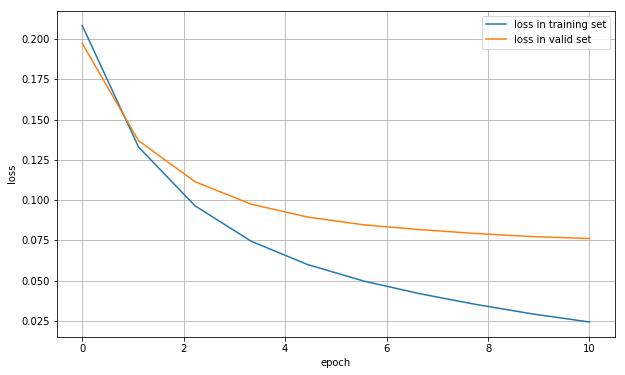

In [39]:
plt.figure(figsize=(10,6))
xaxis = np.linspace(0, 10, 10)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(xaxis, loss_train, '-')
plt.plot(xaxis, loss_valid, '-')
plt.legend(('loss in training set', 'loss in valid set'))
plt.grid()
plt.show()

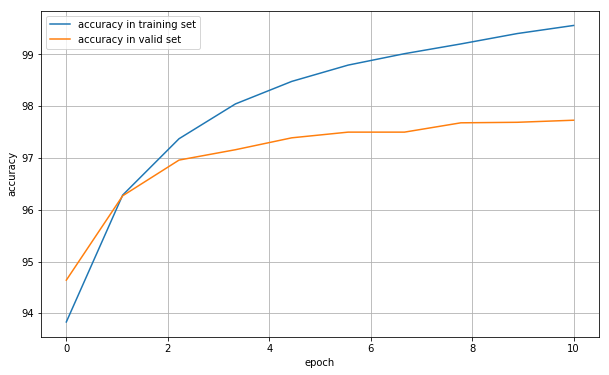

In [40]:
plt.figure(figsize=(10,6))
xaxis = np.linspace(0, 10, 10)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(xaxis, accu_train, '-')
plt.plot(xaxis, accu_valid, '-')
plt.legend(('accuracy in training set', 'accuracy in valid set'))
plt.grid()
plt.show()

__Validate Gradients using Finite Difference__ The finite difference gradient approximation of a scalar function $x\in R \rightarrow f(x)\in R$, of precision $\epsilon$, is defined as $\frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Consider the second layer weights of the MLP you built in the previous section, as a vector $\theta = (\theta_1, ... , \theta_m)$. We are interested in approximating the gradient of the loss function L, evaluated using one training sample, at the end of training, with respect to $\theta_{1:p}$, the first $p=min(10,m)$ elements of $\theta$, using finite differences.

1. Evaluate the finite difference gradients $\nabla^N \in R^p$ using $\epsilon = \frac{1}{N}$ for different values of N

$$\nabla_i^N = \frac{L(\theta_1,...,\theta_{i-1},\theta_{i+\epsilon},...,\theta_p)-L(\theta_1,...,\theta_{i-1},\theta_{i-\epsilon},...,\theta_p)}{2\epsilon}$$

Using at least 5 values of N from the set $\{k10^i: i\in \{0,...,5\}, k\in\{1,5\}\}$

2. Plot the maximum difference between the true gradient and the finite difference gradient ($max_{1\leq i\leq p}|\nabla_i^N-\frac{\partial L}{\partial \theta_i}|$) as a function of N. Comment on the result.

In [20]:
#=== Validate Gradients using Finite Difference ===

def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:

        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1, 1))
        keys = keys + [key] * new_vector.shape[0]

        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1
    return theta, keys


def vector_to_dictionary(theta, features, h1, h2, outputs):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    network structure: 3,2,3,2
    """
    parameters = {}
    w1_t = h1 * features
    b1_t = w1_t + h1

    w2_t = b1_t + h2 * h1
    b2_t = w2_t + h2

    w3_t = b2_t + outputs * h2
    b3_t = w3_t + outputs

    parameters["W1"] = theta[:w1_t].reshape((h1, features))  # w1: h1*features=6
    parameters["b1"] = theta[w1_t:b1_t].reshape((h1, 1))  # b1: h1=2
    parameters["W2"] = theta[b1_t:w2_t].reshape((h2, h1))  # w2: h2*h1=6
    parameters["b2"] = theta[w2_t:b2_t].reshape((h2, 1))  # b2: h2*1=3
    parameters["W3"] = theta[b2_t:w3_t].reshape((outputs, h2))  # w3: outputs*h2=6
    parameters["b3"] = theta[w3_t:b3_t].reshape((outputs, 1))  # b3: outputs*1=2
    return parameters

def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1, 1))

        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1
    return theta

In [29]:
P1_valid = MLP_NN()

train_data, train_label, valid_data, valid_label, test_data, test_label = P1_valid.import_data()
X = train_data[5,:] # choose the fifth sample
X = X.reshape((1, 784))

y = train_label[5]
y = y.reshape((1,1))
y_onehot = P1_valid.one_hot(y)

m = X.shape[0]

# setting the network structure
P1_valid.features = 784
P1_valid.outputs = 10
P1_valid.h1 = 600
P1_valid.h2 = 600
P1_valid.minibatches = 1
P1_valid.epoch = 1
P1_valid.learning_rate = 0.0001

w1_t = P1_valid.h1 * P1_valid.features
b1_t = w1_t + P1_valid.h1

w2_t = b1_t + P1_valid.h2 * P1_valid.h1
b2_t = w2_t + P1_valid.h2

p = min(10, b2_t-b1_t)

w1, w2, w3 = P1_valid.initialize_weights('glorot')
b1, b2, b3 = P1_valid.initialize_biases()
parameters = {"W1": w1,
              "b1": b1,
              "W2": w2,
              "b2": b2,
              "W3": w3,
              "b3": b3}

print('NN structure: {0} * {1}, with epoch: {2}, minibatch: {3}, learning rate: {4}'.format(P1_valid.h1, P1_valid.h2, P1_valid.epoch, P1_valid.minibatches, P1_valid.learning_rate))
print('active function in layer 1: relu')
print('active function in layer 2: relu')

cache = P1_valid.forward(X, parameters)
#loss = P1_valid.loss(X, y, cache)
#print('J orig: ', loss)

gradients = P1_valid.back_propagation(X, y_onehot, cache)

grad = gradients_to_vector(gradients)

grad_l2 = grad[b1_t:b1_t+p].T
#print('grad_l2: ', grad_l2)

grad_backpropogation = grad_l2.tolist()
#print('grad back: ', grad_backpropogation)

# compare grad list: grad[b1_t:b1_t+p]

# Create N set:
N = []
N_set = []
e_set = []

for i in range(6):
    N.append(1*10**i)
    N.append(5*10**i)

random.shuffle(N)
N_set = N[0:5]

N_set.sort()

for r in range(5):
    e_set.append(1/N_set[r])

grad_finite = []
grad_finites = []
for l in range(p):
    for e in range(len(e_set)):
        parameters_values, _ = dictionary_to_vector(parameters)
        thetaplus = np.copy(parameters_values)  # Step 1
        thetaplus[b1_t+l][0] = thetaplus[b1_t+l][0] + e_set[e]  # Step 2, calculate the from and end index for each layer
        plus = vector_to_dictionary(thetaplus, P1_valid.features, P1_valid.h1, P1_valid.h2, P1_valid.outputs)
        plus_cache = P1_valid.forward(X, plus)
        J_plus = P1_valid.loss(X, y, plus_cache)
        #print('J_plus: ', J_plus)

        thetaminus = np.copy(parameters_values)  # Step 1
        thetaminus[b1_t+l][0] = thetaminus[b1_t+l][0] - e_set[e]  # Step 2
        minus = vector_to_dictionary(thetaminus, P1_valid.features, P1_valid.h1, P1_valid.h2, P1_valid.outputs)
        minus_cache = P1_valid.forward(X, minus)
        J_minus = P1_valid.loss(X, y, minus_cache)  # Step 3
        #print('J_minus: ', J_minus)

        gradapprox = (J_plus - J_minus) / e_set[e] / 2
        grad_finite.append(gradapprox)

grad_finites=np.array(grad_finite)
grad_finites = grad_finites.reshape((10, 5))

max_diffs = []
for q in range(5):
    diff = np.abs(grad_finites[:,q]-grad_backpropogation)
    max_diff = np.max(diff)
    max_diffs.append(max_diff)

print('N set: ', N_set)
print('e set: ', e_set)
print('max diffs: ', max_diffs)


NN structure: 600 * 600, with epoch: 1, minibatch: 1, learning rate: 0.0001
active function in layer 1: relu
active function in layer 2: relu
N set:  [5, 10, 500, 10000, 100000]
e set:  [0.2, 0.1, 0.002, 0.0001, 1e-05]
max diffs:  [2.604756871305014e-08, 6.504299487897214e-09, 7.589318062883876e-12, 1.0364875624446768e-11, 1.0364875624446768e-11]


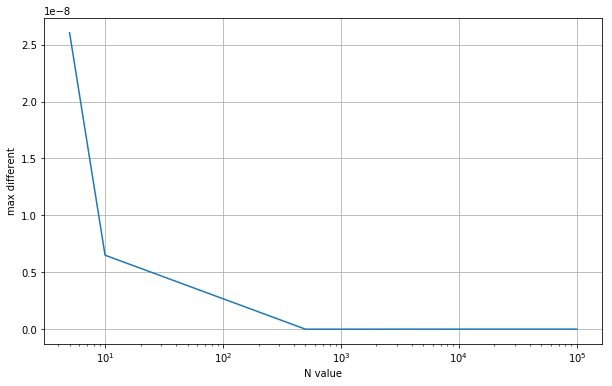

In [30]:
plt.figure(figsize=(10,6))
plt.xlabel("N value")
plt.ylabel("max different")
plt.plot(N_set, max_diffs, '-')
plt.xscale('log')
plt.grid()
plt.show()

__Conclustion__: From the figure showed above, we know that as N value is larger, the $\epsilon$ would be smaller, then the difference between the gradient calculated by back propogation and calculated by finite difference would be smaller. The value of difference should be smaller than $e^{-7}$.